<a href="https://colab.research.google.com/github/bezawit-ayalew/Research-/blob/main/Temporal_Model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
import pickle


from google.colab import drive
drive.mount('/content/drive')

# Step 3: Data Preparation

file_path = '/content/drive/My Drive/Colab Notebooks/NLP Research/data/clean_data_8_context_length_60s_turns (1).pkl'

with open(file_path, 'rb') as f:
    data = pickle.load(f)

print(f"Data type: {type(data)}")

if isinstance(data, list):
    print(f"Length of data: {len(data)}")
    print("First element:", data[0])  # Adjust indexing as needed

# Preview dataset
#print("Dataset Preview:")
df = pd.DataFrame(data)

# Assuming the dataset has 'audio_features', 'facial_landmarks', and 'labels' columns
# Stack facial landmarks


input_features = np.array([
    [sample['speaker_pcm_RMSenergy'], sample['listener_F0_sma'],
     sample['speaker_negate'],sample['listener_pcm_RMSenergy'],
     sample['listener_compare'],sample['listener_WC'],
     sample['listener_turn_duration'], sample['speaker_turn_duration'],
     sample['duration'], sample['speaker_turn_end_timestamp'],
     sample['speaker_turn_duration'], sample['speaker_F0_sma'],
    sample['listener_turn_start_timestamp'], sample['listener_turn_start_timestamp']]
    for sample in data
])

# Create output labels Y (facial landmarks)
labels = np.stack([
    sample['smile_landmarks'] for sample in data
])


#labels = np.array(data['labels'])

# Split the data to training and testing
X_train, X_test, y_train, y_test = train_test_split(input_features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print("The first step>>>> Data preparation complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data type: <class 'list'>
Length of data: 5203
First element: {'start_timestamp': 168903, 'speaker_turn_end_timestamp': 168.783, 'speaker_turn_start_timestamp': 165.44, 'speaker_turn_duration': 3.3429999999999893, 'listener_turn_start_timestamp': 155.44, 'listener_turn_duration': 10.0, 'listener_turn_audio_filename': 'turn_level_audio/0sS4v13DAK8_left/0sS4v13DAK8_left_155.44_165.44.wav', 'speaker_turn_audio_filename': 'turn_level_audio/0sS4v13DAK8_right/0sS4v13DAK8_right_165.44_173.44.wav', 'person': 'left', 'id': '0sS4v13DAK8_frame_idx_8', 'smile_idx': 0, 'speaker_gender': 1, 'speaker_negate': 0.0, 'listener_compare': 0.0, 'listener_WC': 14, 'speaker_pcm_RMSenergy': np.float64(1.0509941203908262), 'listener_F0_sma': np.float64(122.90186924075928), 'IS_SMILE': True, 'intensity_max': 2.0, 'duration': 1.48, 'smile_landmarks': array([[ 27.861023,  47.401505,  39

In [2]:
from torch import nn

# Define the Temporal Transformer model
class TemporalTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_layers, output_dim):
        super(TemporalTransformer, self).__init__()
        if input_dim % num_heads != 0:
            raise ValueError(f"input_dim ({input_dim}) must be divisible by num_heads ({num_heads})")

        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Modify output layer to match expected output size
        self.fc = nn.Linear(input_dim, 8 * 98)  # Adjust output to match y_train_tensor shape (8 * 98)

    def forward(self, x):
        x = self.transformer(x)

        # Aggregate across the sequence, we need the shape (batch_size, 8, 98)
        x = x.mean(dim=1)  # Average over sequence length to get a fixed representation

        # Adjust final output to be of shape (batch_size, 8, 98)
        x = self.fc(x)  # Output size: (batch_size, 8 * 98)

        # Reshape output to match y_train_tensor's shape (batch_size, 8, 98)
        x = x.view(-1, 8, 98)  # Reshaping to match (batch_size, 8, 98)

        return x


#Use batches instead of all.

# Initialize the model
input_dim = X_train_tensor.shape[1]  # Use the correct dimension for the feature size
hidden_dim = 128
num_heads = 4

# Adjust the number of heads dynamically to ensure divisibility with input_dim
while input_dim % num_heads != 0:
    num_heads -= 1
    if num_heads == 0:
        raise ValueError("No valid num_heads found for the given input_dim")

print(f"Adjusted number of heads: {num_heads}")

num_layers = 2
output_dim = 8 * 98  # Adjust output to be 8 landmarks with 98 values each

model = TemporalTransformer(input_dim, hidden_dim, num_heads, num_layers, output_dim)
print("Model initialized.")


#print("X_train_tensor shape:", X_train_tensor.shape)
#print("y_train_tensor shape:", y_train_tensor.shape)

min_len = min(len(X_train_tensor), len(y_train_tensor))

X_train_tensor = X_train_tensor[:min_len]
y_train_tensor = y_train_tensor[:min_len]

#print("X_train_tensor shape:", X_train_tensor.shape)
#print("y_train_tensor shape:", y_train_tensor.shape)



Adjusted number of heads: 1
Model initialized.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [3]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(X_train_tensor.shape)
print(y_train_tensor.shape)

# Initialize the TemporalTransformer model with the correct input_dim
model = TemporalTransformer(input_dim, hidden_dim, num_heads, num_layers, output_dim)
print("Model initialized.")

# Ensure the tensors have the correct shape for the Transformer
# Shape of X_train_tensor should be (batch_size, sequence_length, input_dim)
X_train_tensor = X_train_tensor.squeeze(1)  # Remove extra dimension if necessary
X_test_tensor = X_test_tensor.squeeze(1)  # Remove extra dimension if necessary

# Training loop
def train_model(model, criterion, optimizer, X_train, y_train, epochs=10):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)

        # Ensure y_train is correctly reshaped (it should match the model output shape)
        loss = criterion(outputs, y_train)  # No need for .squeeze() here
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

min_len = min(len(X_test_tensor), len(y_test_tensor))

X_test_tensor = X_test_tensor[:min_len]
y_test_tensor = y_test_tensor[:min_len]


# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)
        mse = criterion(predictions, y_test)
        print(f"Test MSE: {mse.item():.4f}")
    return predictions

# Now, ensure the tensors are correctly shaped: (batch_size, sequence_length, feature_dim)
X_train_tensor = X_train_tensor.unsqueeze(1)  # Adding a sequence dimension
X_test_tensor = X_test_tensor.unsqueeze(1)


# Train the model
train_model(model, criterion, optimizer, X_train_tensor, y_train_tensor, epochs=10)

# Finally, evaluate the model
predictions = evaluate_model(model, X_test_tensor, y_test_tensor)




torch.Size([4162, 13])
torch.Size([4162, 8, 98])
Model initialized.


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 11563.8447
Epoch 2/10, Loss: 11563.7559
Epoch 3/10, Loss: 11563.8096
Epoch 4/10, Loss: 11563.8018
Epoch 5/10, Loss: 11563.8047
Epoch 6/10, Loss: 11563.8242
Epoch 7/10, Loss: 11563.8145
Epoch 8/10, Loss: 11563.8018
Epoch 9/10, Loss: 11563.8008
Epoch 10/10, Loss: 11563.8018
Test MSE: 11568.0264


In [11]:
import torch
import numpy as np

# Define the PCK metric
def pck(predictions, ground_truth, threshold=0.05):
    """
    Calculate the Percentage of Correct Keypoints (PCK).
    The threshold defines how far the predicted keypoint is allowed to be from the true keypoint.

    Arguments:
    predictions -- Model output tensor with predicted keypoints
    ground_truth -- Ground truth tensor with actual keypoints
    threshold -- The allowed error threshold for a keypoint to be considered correct

    Returns:
    pck_score -- The percentage of correct keypoints
    """
    # Calculate Euclidean distance between predictions and ground truth
    distances = torch.norm(predictions - ground_truth, dim=-1)  # Shape: (batch_size, num_keypoints)

    # Define the normalizing factor (for example, max distance between keypoints or max keypoint size)
    norm_factor = torch.norm(ground_truth, dim=-1)  # Assuming normalization by ground truth

    # Calculate how many keypoints are within the threshold
    correct_keypoints = (distances / norm_factor) < threshold  # Boolean mask for keypoints within the threshold

    # Calculate the percentage of correct keypoints for each sample in the batch
    pck_score = correct_keypoints.float().mean()  # Average across keypoints and batch

    return pck_score.item()  # Return as a scalar value

# Evaluation function with PCK
def evaluate_model(model, X_test, y_test, threshold=0.5):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test)

        # Calculate the PCK score
        pck_score = pck(predictions, y_test, threshold)

        print(f"Test PCK: {pck_score:.4f}")
    return predictions

# Now, after training, evaluate the model and print the PCK
predictions = evaluate_model(model, X_test_tensor, y_test_tensor, threshold=1)


Test PCK: 0.6685


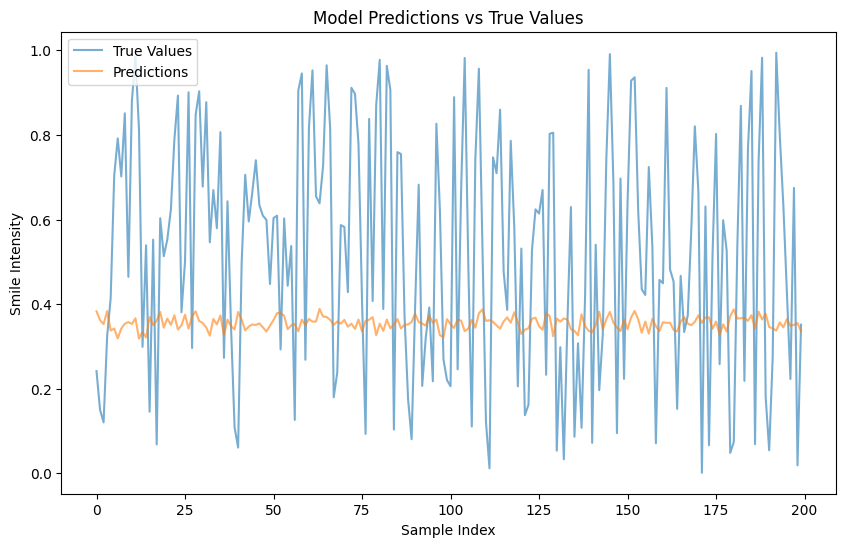

Results analysis complete.


In [ ]:
# Analyze predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.numpy(), label='True Values', alpha=0.6)
plt.plot(predictions.numpy(), label='Predictions', alpha=0.6)
plt.legend()
plt.title("Model Predictions vs True Values")
plt.xlabel("Sample Index")
plt.ylabel("Smile Intensity")
plt.show()

print("Results analysis complete.")
